## Анализ Рисков с помощью VaR

In [1]:
import pandas as pd
import pymongo
import datetime
import numpy as np
from statsmodels.stats.weightstats import zconfint
import matplotlib.pyplot as plt 
%matplotlib inline

У нас слишком много данных, чтобы работать с ними в лоб, поэтому я воспользовался базой данных MongoDB, чтобы ускорить процесс работы с данными торговых операций. В дальнейшем, я действительно убедился, что MongoDB действительно использует гораздо меньше оперативной памяти, чем если бы я все считывал из исходных файлов.

In [2]:
def get_db_object():
    connection = pymongo.MongoClient('localhost', 27017)
    database = connection.MICEX
    return database

Функция, которая импортирует данные с опцией для возможного импорта данных за определенный период.

In [4]:
def import_data(seccode):
    micex_db = get_db_object()
    query = {
        "seccode": seccode#, 
    #    "$and": 
    #    [ 
    #        { "datetime": { "$gt": start } }, 
    #        { "datetime": { "$lt": end } } 
    #    ]
    }
    projection = {
        "_id": 0,
        "volume": 0,
        "seccode": 0
    }
    data = pd.DataFrame(list(micex_db.trade_logs.find(query, projection)))
    return data

Для подсчета VaR я использую нормальное распределение с уровнем доверия $0.05$. Параметр Frequency показывает как часто за весь период я считаю VaR.

In [9]:
def VaR(data, freq):
       
    intervals = np.linspace(0, data.shape[0] - 1, num=freq)
    intervals = [int(i) for i in intervals]
    dates = [(data.datetime.iloc[interval] - data.datetime.iloc[0]).days for interval in intervals]
    VaRs = []
    prices = [data.price.iloc[i] for i in intervals]
    data.price = data.price/data.price.iloc[0]
    

    for i in intervals:
        if i == 0:
            next
        else:
            VaRs.append(zconfint(data[0:i].price))
#            print(dates[j], zconfint(data[0:i].price))

    VaR_lower = [((1 - VaR[0]) * prices[0]) for VaR in VaRs]
    return VaR_lower, dates, prices

In [18]:
def plot_VaR(seccode, VaR, dates):
    plt.plot(dates[1:], VaR, c = 'b')
    plt.xlabel('Days')
    plt.ylabel('Loss per unit of stock, RUB')
    plt.title(seccode)
    plt.show()

In [26]:
def import_and_plot(seccode, frequency):
    start_time = datetime.datetime.now()
    data = import_data(seccode)
    VaRs, dates, prices = VaR(data, 20)
    finish_time = datetime.datetime.now()
    print("Time spent:", finish_time - start_time)
    plot_VaR(seccode, VaRs, dates)
    

Time spent:  0:02:11.171502


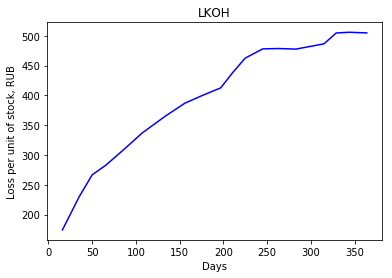

In [27]:
import_and_plot(seccode = 'LKOH', frequency = 36)

Time spent:  0:04:19.406340


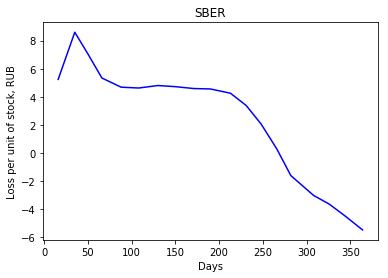

In [28]:
import_and_plot(seccode = 'SBER', frequency = 36)

Time spent:  0:03:05.281101


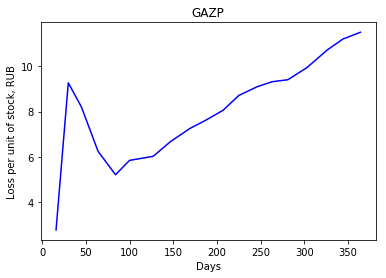

In [29]:
import_and_plot(seccode = 'GAZP', frequency = 36)

In [30]:
%%bash
say finished